- 2D interpolation with unstructured grids

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import random as rn
from mpl_toolkits import mplot3d
import math

## 1.Interpolation over a triangle: nearest neighbour method
![](2022-11-04-20-00-22.png)

In [23]:
def TrNN(r,f,rp):
    w1 = 1/math.sqrt((r[0][0] - rp[0])**2 + (r[0][1] - rp[1])**2)
    w2 = 1/math.sqrt((r[1][0] - rp[0])**2 + (r[1][1] - rp[1])**2)
    w3 = 1/math.sqrt((r[2][0] - rp[0])**2 + (r[2][1] - rp[1])**2)
    
    fp = (w1*f[0] + w2*f[1] + w3*f[2]) / (w1+w2+w3)
    
    return fp

0.4283745086941787


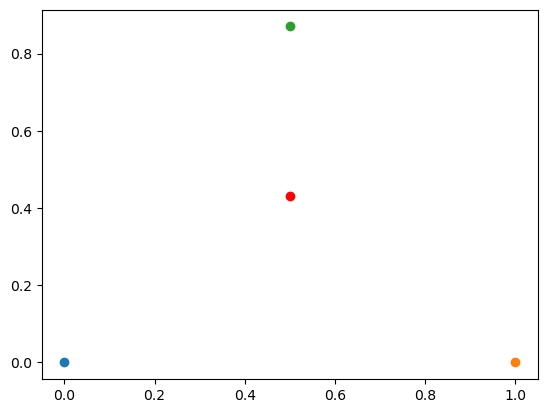

In [24]:
x1 = 0
y1 = 0
x2 = 1
y2 = 0
x3 = 0.5
y3 = 0.87
r = [[x1,y1],[x2,y2],[x3,y3]]

f1 = -2
f2 = 2
f3 = 1
f = [f1,f2,f3]

x4 = 0.5
y4 = 0.43

rp = [x4,y4]


print(TrNN(r,f,rp))


pp.scatter(x1,y1)
pp.scatter(x2,y2)
pp.scatter(x3,y3)
pp.scatter(x4,y4, color="red")



## 2.Interpolation over a triangle: barycentric coordinates
![](2022-11-04-20-01-36.png)

In [25]:
def TrBaryc(r,f,rp):
    l1 = ((r[1][1]-r[2][1]) * (rp[0]-r[2][0]) + (r[2][0]-r[1][0])*(rp[1]-r[2][1])) / ((r[1][1]-r[2][1]) * (r[0][0]-r[2][0]) + (r[2][0]-r[1][0])*(rp[1]-r[2][1]))
    l2 = ((r[2][1]-r[0][1]) * (rp[0]-r[2][0]) + (r[0][0]-r[2][0])*(rp[1]-r[2][1])) / ((r[1][1]-r[2][1]) * (r[0][0]-r[2][0]) + (r[2][0]-r[1][0])*(rp[1]-r[2][1]))
    l3 = 1-l2-l1
    
    fp = l1*f[0] + l2*f[1] + l3*f[2]
    #print(l1 +l2 +l3)
    
    return fp
    

0.3282442748091603


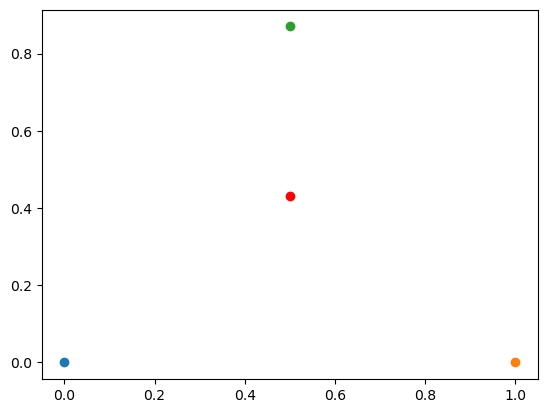

In [26]:
x1 = 0
y1 = 0
x2 = 1
y2 = 0
x3 = 0.5
y3 = 0.87
r = [[x1,y1],[x2,y2],[x3,y3]]

f1 = -2
f2 = 2
f3 = 1
f = [f1,f2,f3]

x4 = 0.5
y4 = 0.43

rp = [x4,y4]


print(TrBaryc(r,f,rp))


pp.scatter(x1,y1)
pp.scatter(x2,y2)
pp.scatter(x3,y3)
pp.scatter(x4,y4, color="red")

## Task C: Interpolation over a triangulated mesh and mesh refinement
![](2022-11-04-20-02-18.png)

In [33]:
# Params
r = 100 # radius
n = 10 # n triangles
L = 1 # mesh refinement level

nglobal = np.ndarray((n+1,2)) # global x,y coordinates of node i
conn = np.zeros((n,3))# nodal vertices 1-2-3 of triangle, as int
conn = conn.astype(int)
f = np.ndarray(n+1) # values of the function at each node
r_= np.ndarray((3,2))
fr = np.ndarray(3)

# generate mesh with N triangles
for i in range(n):
    angle = (i*360/n) * np.pi/180
    # coordinate of each nodes
    nglobal[i,0] = r * np.cos(angle)
    nglobal[i,0] = r * np.cos(angle)
    # value of function on each node
    f[i] = i*360/n
    # connect nodes as vertices of triang
    conn[i,0]= i # current node
    conn[i,0]= i + 1 # next node
    conn[i,2]= n # center of circle

# for central node only
conn[n-1,1] = 0 
nglobal[n,:] = [0,0] # coordinates
f[n] = 360


In [34]:
# Interpolate mesh for L levels

for l in range(0,L):
    Nt = n # number of triangles at this level
    cpconn = np.copy(conn) # store current connectivity
    # number of triangles for the refined mesh (every current triangle will contain three new triangles)
    n = Nt * 3 
    # define array for connectivity 
    conn = np.ndarray((n,3))
    conn = conn.astype(int)

    iconn = 0 # new triangle counter
    Ng = len(nglobal) # current number of global nodes
    
    # for every existing triangle
    for i in range(0,Nt):
        # find the three nodes for this triangle, and their coordinates
        for k in range(0,3):
            # coordinates
            r_[k,:] = nglobal[cpconn[i,k],:]
            # values of f
            fr[k] = f[cpconn[i,k]]
        # establish coordinates of new node, at the centroid
        centrx = ( r_[0,0] + r_[1,0] + r_[2,0] ) / 3
        centry = ( r_[0,1] + r_[1,1] + r_[2,1] ) / 3
       
        # interpolate at the new node (at the centroid)
        rp = [centrx,centry]
        frp = TrBaryc(r_,fr,rp)

        # update connectivity and global nodes
        # append the new node rp to the list of global nodes
        nglobal = np.append(nglobal,[rp],axis=0)
        # append the value of frp
        f = np.append(f,frp)
        
        # update connectivity for the three new triangles
        # first new triangle (iconn): node 0, node 1, new node rp (stored in nglobal at position Ng+1)
        conn[iconn,:] = [cpconn[i,0],cpconn[i,1],Ng+i]
        # second new triangle (iconn+1): node 1, node 2, new node rp (stored in nglobal at position Ng+1)
        conn[iconn+1,:] = [cpconn[i,1],cpconn[i,2],Ng+i]
        # third new triangle (iconn): node 2, node 0, new node rp (stored in nglobal at position Ng+1)
        conn[iconn+2,:] = [cpconn[i,2],cpconn[i,0],Ng+i]
        # update counting for triangles
        iconn += 3

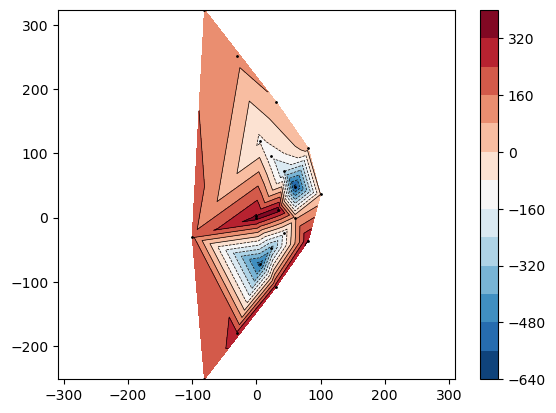

In [36]:
# Plot
x = nglobal[:,0]
y = nglobal[:,1]
fig, (ax1) = plt.subplots(nrows=1)
ax1.plot(x,y,'ko', ms=1)
ax1.axis('equal')
ax1.tricontour(x, y, f, levels=14, linewidths=0.5, colors='k')
cntr1 = ax1.tricontourf(x, y, f, levels=14, cmap="RdBu_r")
fig.colorbar(cntr1, ax=ax1)

Previous attempt below

In [ ]:
cornerlist = [(i,i+1,N) for i in range(0,49) ]
cornerlist = cornerlist + [(N-1,0,N)]
#cornerlist

In [ ]:
newNodes = []

for i in range(0,len(cornerlist)):
    p0, p1, p2 = cornerlist[i][0],cornerlist[i][1],cornerlist[i][2] 
    x0, x1, x2 = points[p0][0], points[p1][0], points[p2][0]
    y0, y1, y2 = points[p0][1], points[p1][1], points[p2][1]
    xnew = (x0 + x1 + x2)/3
    ynew = (y0 + y1 + y2)/3
    newNodes = newNodes + [(xnew,ynew)]
    


IndexError: list index out of range

IndexError: list index out of range

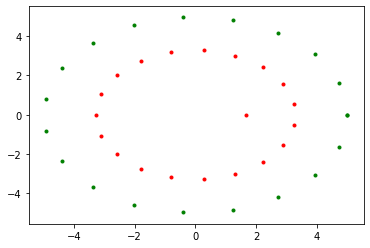

In [ ]:
for i in range(0,len(newNodes)):
    pp.scatter(points[i][0], points[i][1], marker=".",color='g')
    pp.scatter(newNodes[i][0], newNodes[i][1],marker=".",color='r')
pp.scatter(points[50][0], points[50][1],marker=".",color='g', linewidth=1)
pp.grid()



In [ ]:
for i in range(0,N-1):
    # point at which we want the value
    rp = newNodes[i]
    # coordinates of corners to input
    p0, p1, p2 = cornerlist[i][0],cornerlist[i][1],cornerlist[i][2] 
    x0, x1, x2 = points[p0][0], points[p1][0], points[p2][0]
    y0, y1, y2 = points[p0][1], points[p1][1], points[p2][1]
    # values of the points
    fpoints = [f[p0], f[p1], f[p2]]
    rpoints = [[x0,y0],[x1,y1],[x2,y2]]
    value = TrBaryc(rpoints,fpoints,rp)
    print(value)

18.258255180187682
144.1527698302878
187.82491199932988
191.86886877220792
157.85322018371605
46.88546895118881
-320.4303179540708
-1122.166036027441
-320.5119434030463
107.99999999999986
228.58759197289908
271.32760320588284
286.7785001323582
287.15618043905624
271.05084696656604
218.43181556052366
62.48875716283601
115.12617698483109
306.00000000000006


(3.3333333333333335, -4.082155997157844e-16)